In [1]:
!pip install gymnasium

In [2]:
# استيراد المكتبات اللازمة
import gymnasium as gym
import numpy as np
import random

In [3]:
# تهيئة البيئة
env = gym.make('MountainCar-v0', render_mode='rgb_array')

In [4]:
# إعداد جدول القيم النوعية
n_bins = 20  # عدد الفئات لكل من الموقع والسرعة
# تهيئة جدول القيم النوعية
q_table = np.zeros((n_bins, n_bins, env.action_space.n))

In [5]:
# دالة لتقسيم الحالة المستمرة إلى فئات
def discretize_state(state, n_bins=n_bins):
    # الموقع والسرعة من الحالة
    position, velocity = state

    # إنشاء قائمة قئات المواقع
    position_bins = np.linspace(-1.2, 0.6, n_bins)
    # إنشاء قائمة قئات السرعات
    velocity_bins = np.linspace(-0.07, 0.07, n_bins)

    # إيجاد فهرس الفئة الموافقة للموقع
    pos_idx = np.digitize(position, position_bins) - 1

    # إيجاد فهرس الفئة الموافقة للسرعة
    vel_idx = np.digitize(velocity, velocity_bins) - 1

    # إرجاع الفهارس الخاصة بالموقع والسرعة
    return pos_idx, vel_idx

In [6]:
# معاملات التعلم النوعي
learning_rate = 0.1  # معدل التعلم
discount_factor = 0.99  # عامل الخصم
epsilon = 1.0  # عامل الاستكشاف
epsilon_decay = 0.995  # معدل انخفاض إبسيلون
epsilon_min = 0.05  # الحد الأدنى من إبسيلون

In [7]:
# دالة لاختيار الفعل باستخدام إبسيلون
def epsilon_greedy(state, epsilon):
    # إذا كان العدد العشوائي أقل من إبسيلون، نستكشف
    if np.random.rand() < epsilon:
        # اختيار فعل عشوائي
        return env.action_space.sample()
    # إذا كان العدد العشوائي أكبر من إبسيلون، نستخدم المعرفة السابقة
    else:
        # اختيار الفعل الذي له أعلى قيمة
        return np.argmax(q_table[state])

In [8]:
num_episodes = 10000  # عدد الحلقات التدريبية
train_rewards = [] # قائمة مكافآت الحلقات

In [9]:
# حلقة التدريب الرئيسية
for episode in range(num_episodes):
    # إعادة تهيئة البيئة في بداية كل حلقة
    state, _ = env.reset()
    # تقسيم الحالة المستمرة إلى فئات
    state_disc = discretize_state(state)
    done = False
    total_reward = 0

    # حلقة  لتحديث القيم بناءً على الأفعال التي يتم اتخاذها
    while not done:
        # اختيار الفعل
        action = epsilon_greedy(state_disc, epsilon)
        # تطبيق الفعل والحصول على النتيجة
        next_state, reward, terminated, truncated, info = env.step(action)
         # تقسيم الحالة التالية
        next_state_disc = discretize_state(next_state)

        # تحديث جدول القيم
        q_table[state_disc][action] = q_table[state_disc][action] + \
                         learning_rate * (reward + discount_factor * \
                         np.max(q_table[next_state_disc]) - q_table[state_disc][action])


        state_disc = next_state_disc  # تحديث الحالة
        total_reward += reward  # إضافة المكافأة

        if terminated or truncated:
            done = True  # نهاية الحلقة

    # تقليل إبسيلون بعد كل حلقة
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 1000 == 0:
        print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

Episode 1000/10000, Total Reward: -200.0, Epsilon: 0.050
Episode 2000/10000, Total Reward: -200.0, Epsilon: 0.050
Episode 3000/10000, Total Reward: -182.0, Epsilon: 0.050
Episode 4000/10000, Total Reward: -148.0, Epsilon: 0.050
Episode 5000/10000, Total Reward: -200.0, Epsilon: 0.050
Episode 6000/10000, Total Reward: -179.0, Epsilon: 0.050
Episode 7000/10000, Total Reward: -159.0, Epsilon: 0.050
Episode 8000/10000, Total Reward: -153.0, Epsilon: 0.050
Episode 9000/10000, Total Reward: -180.0, Epsilon: 0.050
Episode 10000/10000, Total Reward: -141.0, Epsilon: 0.050


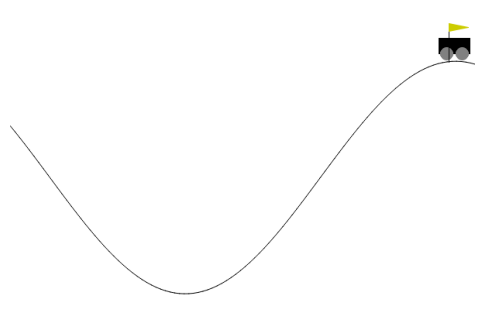

In [10]:
# مكتبة العرض
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

 # إعادة تهيئة البيئة للاختبار بعد التدريب
state, info = env.reset()
# تقسيم الحالة المستمرة إلى فئات
state_disc = discretize_state(state)  # تقسيم الحالة المستمرة إلى فئات
done = False
total_reward = 0

# إنشاء الشكل لعرض البيئة
fig, ax = plt.subplots(figsize=(6, 6))

# حلقة الاختبار لتقييم أداء الوكيل بعد التدريب
while not done:
    # اختيار أفضل فعل
    action = np.argmax(q_table[state_disc[0], state_disc[1]])
    # تنفيذ الفعل في البيئة
    next_state, reward, terminated, truncated, info = env.step(action)
    # تقسيم الحالة التالية إلى فئات
    next_state_disc = discretize_state(next_state)

    # الحصول على الإطار (الصورة) من البيئة
    frame = env.render()

    # تحديث الرسم البياني بالإطار الجديد
    ax.clear()  # مسح الإطار السابق
    ax.imshow(frame)  # عرض الإطار الحالي
    ax.axis('off')  # إخفاء المحاور لتوفير عرض أفضل

    # مسح الإطار السابق وعرض الشكل الجديد
    clear_output(wait=True)  # مسح الإطار السابق من العرض
    display(fig)  # عرض الشكل الجديد
    plt.pause(0.05)  # الانتظار لفترة قصيرة لإنشاء تأثير الحركة

    total_reward += reward  # جمع المكافآت خلال الاختبار
    state_disc = next_state_disc  # الانتقال إلى الحالة التالية

    # التحقق مما إذا كانت الحلقة قد انتهت
    if terminated or truncated:
        done = True


In [11]:
# طباعة المكافأة الإجمالية بعد اختبار الوكيل
print(f"Total Reward after Test: {total_reward}")


Total Reward after Test: -176.0


In [12]:
# إغلاق البيئة بعد الانتهاء من الاختبار
env.close()